In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
import optuna 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings
from scipy.signal import savgol_filter
from scipy.stats import skew, kurtosis, entropy
import torch.nn.functional as F
from torch.autograd import grad
from sklearn.preprocessing import StandardScaler



%matplotlib inline

In [2]:
def set_seed(s):
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed(s)

set_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class Battery:
    """
    Minimal Battery class following the article / repo logic.
    - Accepts one .pkl path (Tongji-format) in constructor
    - Builds X (16 stats + normalized time) and y (SOH)
    - Keeps ICA computation (as in repo)
    - Provides make_pinn_pairs() and build_dataloaders()
    All tensors are torch.float32 and moved to automatic device (cuda if available).
    No extra safety checks, no NaN-zeroing — faithful to original code flow.
    """

    
    def __init__(self, path, batch_size=32, stats_mode='auto', nominal_capacity=1100):
        # device auto
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # load same structure as in repo
        pkl = pd.read_pickle(path)
        self.battery_id = path.split('/')[-1].split('.')[0]
        self.data = pkl[self.battery_id]
        self.cycle_data = self.data['data']       # dict-like: 1..N -> DataFrame
        self.cycle_life = len(self.cycle_data)

        self.capacity = np.array([self.cycle_data[i]['Capacity (mAh)'].max() for i in range(1, self.cycle_life+1)])
        if nominal_capacity is None:
            nominal_capacity = self.capacity.max()
        self.soh = (self.capacity / nominal_capacity).astype(np.float32)  # raw SOH values

        self.cccv_tables = [self.get_CCCV_stage(i) for i in range(1, self.cycle_life+1)]

        stats_list = [self._stats_from_table(df, mode=stats_mode) for df in self.cccv_tables]
        self.stats = np.vstack(stats_list).astype(np.float32)  # shape (N,16)

        N = self.stats.shape[0]
        self.time = (np.arange(N) / float(N)).reshape(-1,1).astype(np.float32)

        X_np = np.hstack([self.stats, self.time])        # (N,17)
        y_np = self.soh.reshape(-1,1)                    # (N,1)
        scaler = StandardScaler()
        X_np = scaler.fit_transform(X_np)
        self.X = torch.tensor(X_np, dtype=torch.float32, device=self.device)
        self.y = torch.tensor(y_np, dtype=torch.float32, device=self.device)

        self._ica_features()

    def get_CCCV_stage(self, cycle):
        df = self.cycle_data[cycle]
        return df.loc[df['Status'] == 'Constant current-constant voltage charge', :]

    def get_CC_stage(self, cycle, voltage_range=None):
        cccv = self.get_CCCV_stage(cycle)
        split_idx = cccv.loc[cccv['Voltage (V)'] >= 3.595, :].index[0]
        cc_df = cccv.loc[:split_idx, :]

        if voltage_range is None:
            return cc_df
        else:
            return cc_df.loc[(cc_df['Voltage (V)'] >= voltage_range[0]) & (cc_df['Voltage (V)'] <= voltage_range[1]), :]

    def get_CV_stage(self, cycle, current_range=None):
        cccv = self.get_CCCV_stage(cycle)
        split_idx = cccv.loc[cccv['Voltage (V)'] >= 3.595, :].index[0]
        cv_df = cccv.loc[split_idx:, :]
        if current_range is None:
            return cv_df
        else:
            return cv_df.loc[(cv_df['Current (mA)'] >= current_range[1]) & (cv_df['Current (mA)'] <= current_range[0]), :]

   
    def compute_charge_features(self, df):
        current = df['Current (mA)'].values.astype(float)
        time = df['Time (s)'].values.astype(float)
    
        # dQ = I * dt / 3600  (перевод секунд в часы)
        dt = np.diff(time, prepend=time[0])
        dQ = current * dt / 3600.0
        Q = np.cumsum(dQ)  # накопленный заряд
    
        total_charge = Q[-1] if len(Q) > 0 else 0.0
        # mean_rate = np.mean(current) if len(current) > 0 else 0.0
    
        return np.array([total_charge], dtype=float)

    def _stats_for_signal(self, sig, time_seg):

        sig = np.array(sig, dtype=float)
        dt = np.gradient(time_seg)
        slope = np.gradient(sig, time_seg)
    
        hist, _ = np.histogram(sig, bins=30, density=True)
        hist = hist + 1e-12
    
        features = np.array([
            np.mean(sig),
            np.std(sig),
            skew(sig),
            kurtosis(sig),
            time_seg[-1] - time_seg[0],
            np.mean(np.abs(slope)),
            entropy(hist)
        ], dtype=float)
    
        return features

    def _stats_from_table(self, df_cccv, mode='auto'):
        split_idx = df_cccv.loc[df_cccv['Voltage (V)'] >= 3.595, :].index[0]
        df_cc = df_cccv.loc[:split_idx:, :]
        df_cv = df_cccv.loc[split_idx:, :]

        

        # Сигналы для статистик
        V = df_cccv['Voltage (V)'].values.astype(float)
        I = df_cccv['Current (mA)'].values.astype(float)
        T = df_cccv['Time (s)'].values.astype(float)
    
        # Выделение сегментов по твоей логике (auto)
        if mode == 'auto':
            v_min = V.max() - 0.5
            mask_v = (V >= v_min) & (V <= V.max())
            mask_i = np.ones_like(I, dtype=bool)
        else:
            mask_v = np.ones_like(V, dtype=bool)
            mask_i = np.ones_like(I, dtype=bool)
    
        V_seg = V[mask_v]
        T_v = T[mask_v]
        I_seg = I[mask_i]
        T_i = T[mask_i]
    
        feat_V = self._stats_for_signal(V_seg, T_v)
        feat_I = self._stats_for_signal(I_seg, T_i)
    

        charge_CC = self.compute_charge_features(df_cc)
        charge_CV = self.compute_charge_features(df_cv)

        return np.concatenate([feat_V, feat_I, charge_CC, charge_CV], axis=0)




    def _ica_features(self):
        feats = []
        dqdv_list = []
        volt_list = []
        for cycle in range(1, self.cycle_life+1):
            df = self.cycle_data[cycle]
            df = df.loc[df['Status'] == 'Constant current discharge_0', :]
            voltage = df['Voltage (V)'].values.astype(float)
            current = df['Current (mA)'].values.astype(float)
            time = df['Time (s)'].values.astype(float)

            dt = np.diff(time, prepend=time[0]) / 3600.0
            Q = np.cumsum(np.abs(current) * dt)

            dQ = np.gradient(Q)
            dV = np.gradient(voltage)
            dQ_dV = dQ / (dV + 1e-8)
            dQ_dV_smooth = savgol_filter(dQ_dV, window_length=min(31, dQ_dV.shape[0] if dQ_dV.shape[0]%2==1 else dQ_dV.shape[0]-1), polyorder=2) \
                            if dQ_dV.shape[0] >= 5 else dQ_dV
            peak_height = np.min(dQ_dV_smooth)
            peak_idx = np.argmin(dQ_dV_smooth)
            peak_voltage = voltage[peak_idx]
            area_under_curve = np.trapz(dQ_dV_smooth, voltage)
            feats.append([peak_height, peak_voltage, area_under_curve])
            dqdv_list.append(dQ_dV_smooth)
            volt_list.append(voltage)

        self.ica = np.array(feats, dtype=float)
        scaler = StandardScaler()
        self.ica = scaler.fit_transform(self.ica)
        self.dqdv = dqdv_list
        self.volt = volt_list
        
    def build_ica(self, diap=(float('-inf'), float('inf')), num=100):
        fig, ax = plt.subplots()
        for n, (v, ic) in enumerate(zip(self.volt, self.dqdv)):
            if n > num: 
                break
            mask = (v > diap[0]) & (v < diap[1])
            ax.plot(v[mask], 1000 * ic[mask])
            dqdv_max = ic.min()
            v_max = v[ic.argmin()]
            ax.plot(v_max, 1000 * dqdv_max, marker='*', color='red')
        ax.set_xlabel(r'Voltage (V)', fontsize=15)
        ax.set_ylabel(r'dQ/dV (mAh/V)', fontsize=15)
        ax.set_title(f'All ica for {self}')
    
    def __str__(self):
        return 'Battery'

def results(y_test, y_pred, ax = None, 
           label=''):
    """
    Plot and calculate metrics for SOH predictions.
    
    Returns:
        dict with r2, rmse, mae metrics
    """
    if isinstance(y_test, torch.Tensor):
        y_test = y_test.detach().cpu().numpy().flatten()
        
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy().flatten()
        
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f'R2 score = {r2:.3f}')
    print(f'rmse = {100 * rmse:.3f}%')
    print(f'mae = {mae:.3f}')
    if ax is None:
        fig, ax = plt.subplots(figsize=(15,15))
    cycles = np.arange(1, len(y_test) + 1)
    ax.plot(cycles, y_test, color='red', label='Test SOH')
    ax.plot(cycles, y_pred, color='green', label='Predicted SOH')
    ax.set_xlabel('Cycle', fontsize=20)
    ax.set_ylabel('SOH', fontsize=20)
    ax.set_title(label, fontsize=20)
    plt.grid()
    ax.legend(fontsize=15)
    return {'r2': r2, 'rmse': rmse, 'mae': mae}



In [4]:

class MLP(nn.Module):
    def __init__(self, inp, out, hidden=64, layers=3, drop=0.2):
        super().__init__()
        net = []
        for i in range(layers):
            net += [nn.Linear(inp if i == 0 else hidden, hidden), nn.SiLU(), nn.Dropout(drop)]
        net.append(nn.Linear(hidden, out))
        self.net = nn.Sequential(*net)
    def forward(self, x): 
        return self.net(x)


class PINN(nn.Module):
    def __init__(self, feat_dim=16):
        super().__init__()
        self.F = MLP(inp=feat_dim+1, out=1, hidden=64, layers=3)     # u = F(t, x)
        self.G = MLP(inp=feat_dim + 1 + 1 + feat_dim + 1, out=1, hidden=64, layers=3)  # g = G(t,x,u,u_x,u_t)

    def forward(self, xt):
        xt = xt.requires_grad_(True)
        u = self.F(xt)                                
        grads = grad(u.sum(), xt, create_graph=True)[0]  
        u_x = grads[:, :-1]                             
        u_t = grads[:, -1:]                              
        G_in = torch.cat([xt, u, u_x, u_t], 1)
        g = self.G(G_in)
        f = u_t - g                                 
        return u, f

def pinn_loss(model, x1, x2, y1, y2, alpha=1.0, beta=1.0):
    u1, f1 = model(x1)
    u2, f2 = model(x2)
    L_data = 0.5*(F.mse_loss(u1, y1) + F.mse_loss(u2, y2))
    zeros = torch.zeros_like(f1)
    L_pde = 0.5*(F.mse_loss(f1, zeros) + F.mse_loss(f2, zeros))
    L_mono = F.relu((u2 - u1) * (y1 - y2)).mean()
    return L_data + alpha*L_pde + beta*L_mono

def train_pinn(model, tr_dl, val_dl, optimizer=None, scheduler=None, 
               epochs=300, alpha=1.0, beta=1.0):

    if optimizer is None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

    train_losses, val_losses = [], []
    model.to(device)

    for epoch in tqdm(range(epochs), desc="Training PINN"):
        model.train()
        train_loss = 0.0

        for x1, x2, y1, y2 in tr_dl:
            x1 = x1.to(device).requires_grad_(True)
            x2 = x2.to(device).requires_grad_(True)
            y1 = y1.to(device)
            y2 = y2.to(device)

            loss = pinn_loss(model, x1, x2, y1, y2, alpha, beta)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        if scheduler: 
            scheduler.step()

        train_loss = train_loss / len(tr_dl)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        for xv1, xv2, yv1, yv2 in val_dl:
            xv1 = xv1.to(device).requires_grad_(True)
            xv2 = xv2.to(device).requires_grad_(True)
            yv1 = yv1.to(device)
            yv2 = yv2.to(device)
            
            val_loss = pinn_loss(model, xv1, xv2, yv1, yv2, alpha, beta)
            val_loss += val_loss.item()

        val_loss = val_loss / len(val_dl)
        val_losses.append(val_loss.item())
    return train_losses, val_losses


def test_pinn(model, X_train, y_train, X_val, y_val,
             X_test, y_test): 
    model.eval()
    
    if X_val and y_val:
        fig, axes = plt.subplots(3, 1, figsize=(10, 30))
    else:
        fig, axes = plt.subplots(2, 1, figsize=(10, 20))
        
    results(y_train.cpu().detach().numpy(), 
            model(X_train)[0].cpu().detach().numpy(), ax=axes[0], label='Train PINN')
    if X_val and y_val:
        results(y_val.cpu().detach().numpy(), 
            model(X_val)[0].cpu().detach().numpy(), ax=axes[1], label='Validation PINN')

    results(y_test.cpu().detach().numpy(), 
        model(X_test)[0].cpu().detach().numpy(), ax=axes[2 - int(X_val is None)], label='Testing PINN')

In [5]:
def get_data(bats, ica=False):
    if not ica:
        X = torch.cat([bat.X for bat in bats], 0)
        y = torch.cat([bat.y for bat in bats], 0)
    else:
        X = torch.cat([torch.cat([bat.X,torch.tensor(bat.ica, dtype=torch.float32).to(device)], 1)
                     for bat in bats], 0)

        y = torch.cat([bat.y for bat in bats], 0)
        
    
    def make_pinn_pairs(X, y):
        x1 = X[:-1]
        x2 = X[1:]
        y1 = y[:-1]
        y2 = y[1:]
        return x1, x2, y1, y2
    
    
    ds = TensorDataset(*make_pinn_pairs(X, y))
    
    dl = DataLoader(ds, shuffle=True, batch_size=64)
   
    return X, y, dl
    

In [9]:
columns = [f'V_mean', f'V_std', f'V_skew', f'V_kurtosis', f'CV_charging_time',
f'CV_accum_charge', f'V_slope_mean',f'V_entropy', 
f'I_mean', f'I_std', f'I_skew', f'I_kurtosis',
f'CC_charging_time', f'CC_accum_charge',
f'I_slope_mean', f'I_entropy', f'Time', f'ica_peak_h', f'ica_peak_v', 
f'ica_square', f'SOH']

def corr_with_soh(bat, tick=True, xsize=10):
    x = np.concatenate([bat.X.cpu().detach().numpy(),
                        bat.ica, 
                        bat.y.cpu().detach().numpy().reshape(-1, 1)], axis=-1)
    plt.figure(figsize=(16, 2))
    df = pd.DataFrame(x, columns=columns)

    # sns.heatmap(df.corr().iloc[-1, :-1].to_frame(name='Корреляция с SOH').T, annot=True, fmt='.2f')
    sns.heatmap(df.corr().iloc[-1, :-1].to_frame(name='Корреляция с SOH').T, 
                annot=True, fmt='.2f', xticklabels=tick)
    plt.xticks(fontsize=xsize)


# FILE_WAY = '/kaggle/input/hust-dataset/our_data/'
# test_idx = ['1-4','1-8','2-4', '10-4','10-8']
# test_idx = ['10-8']

# bats = [Battery(f'{FILE_WAY}/{i}.pkl') for i in tqdm(test_idx)]
# for i, bat in enumerate(bats):
#     corr_with_soh(bat, tick=True)
    
    

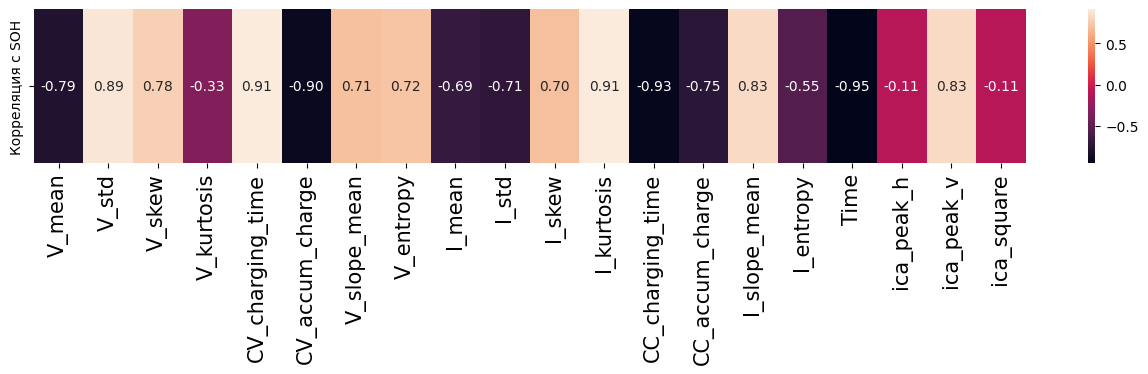

In [10]:
corr_with_soh(bat, tick=True, xsize=15)

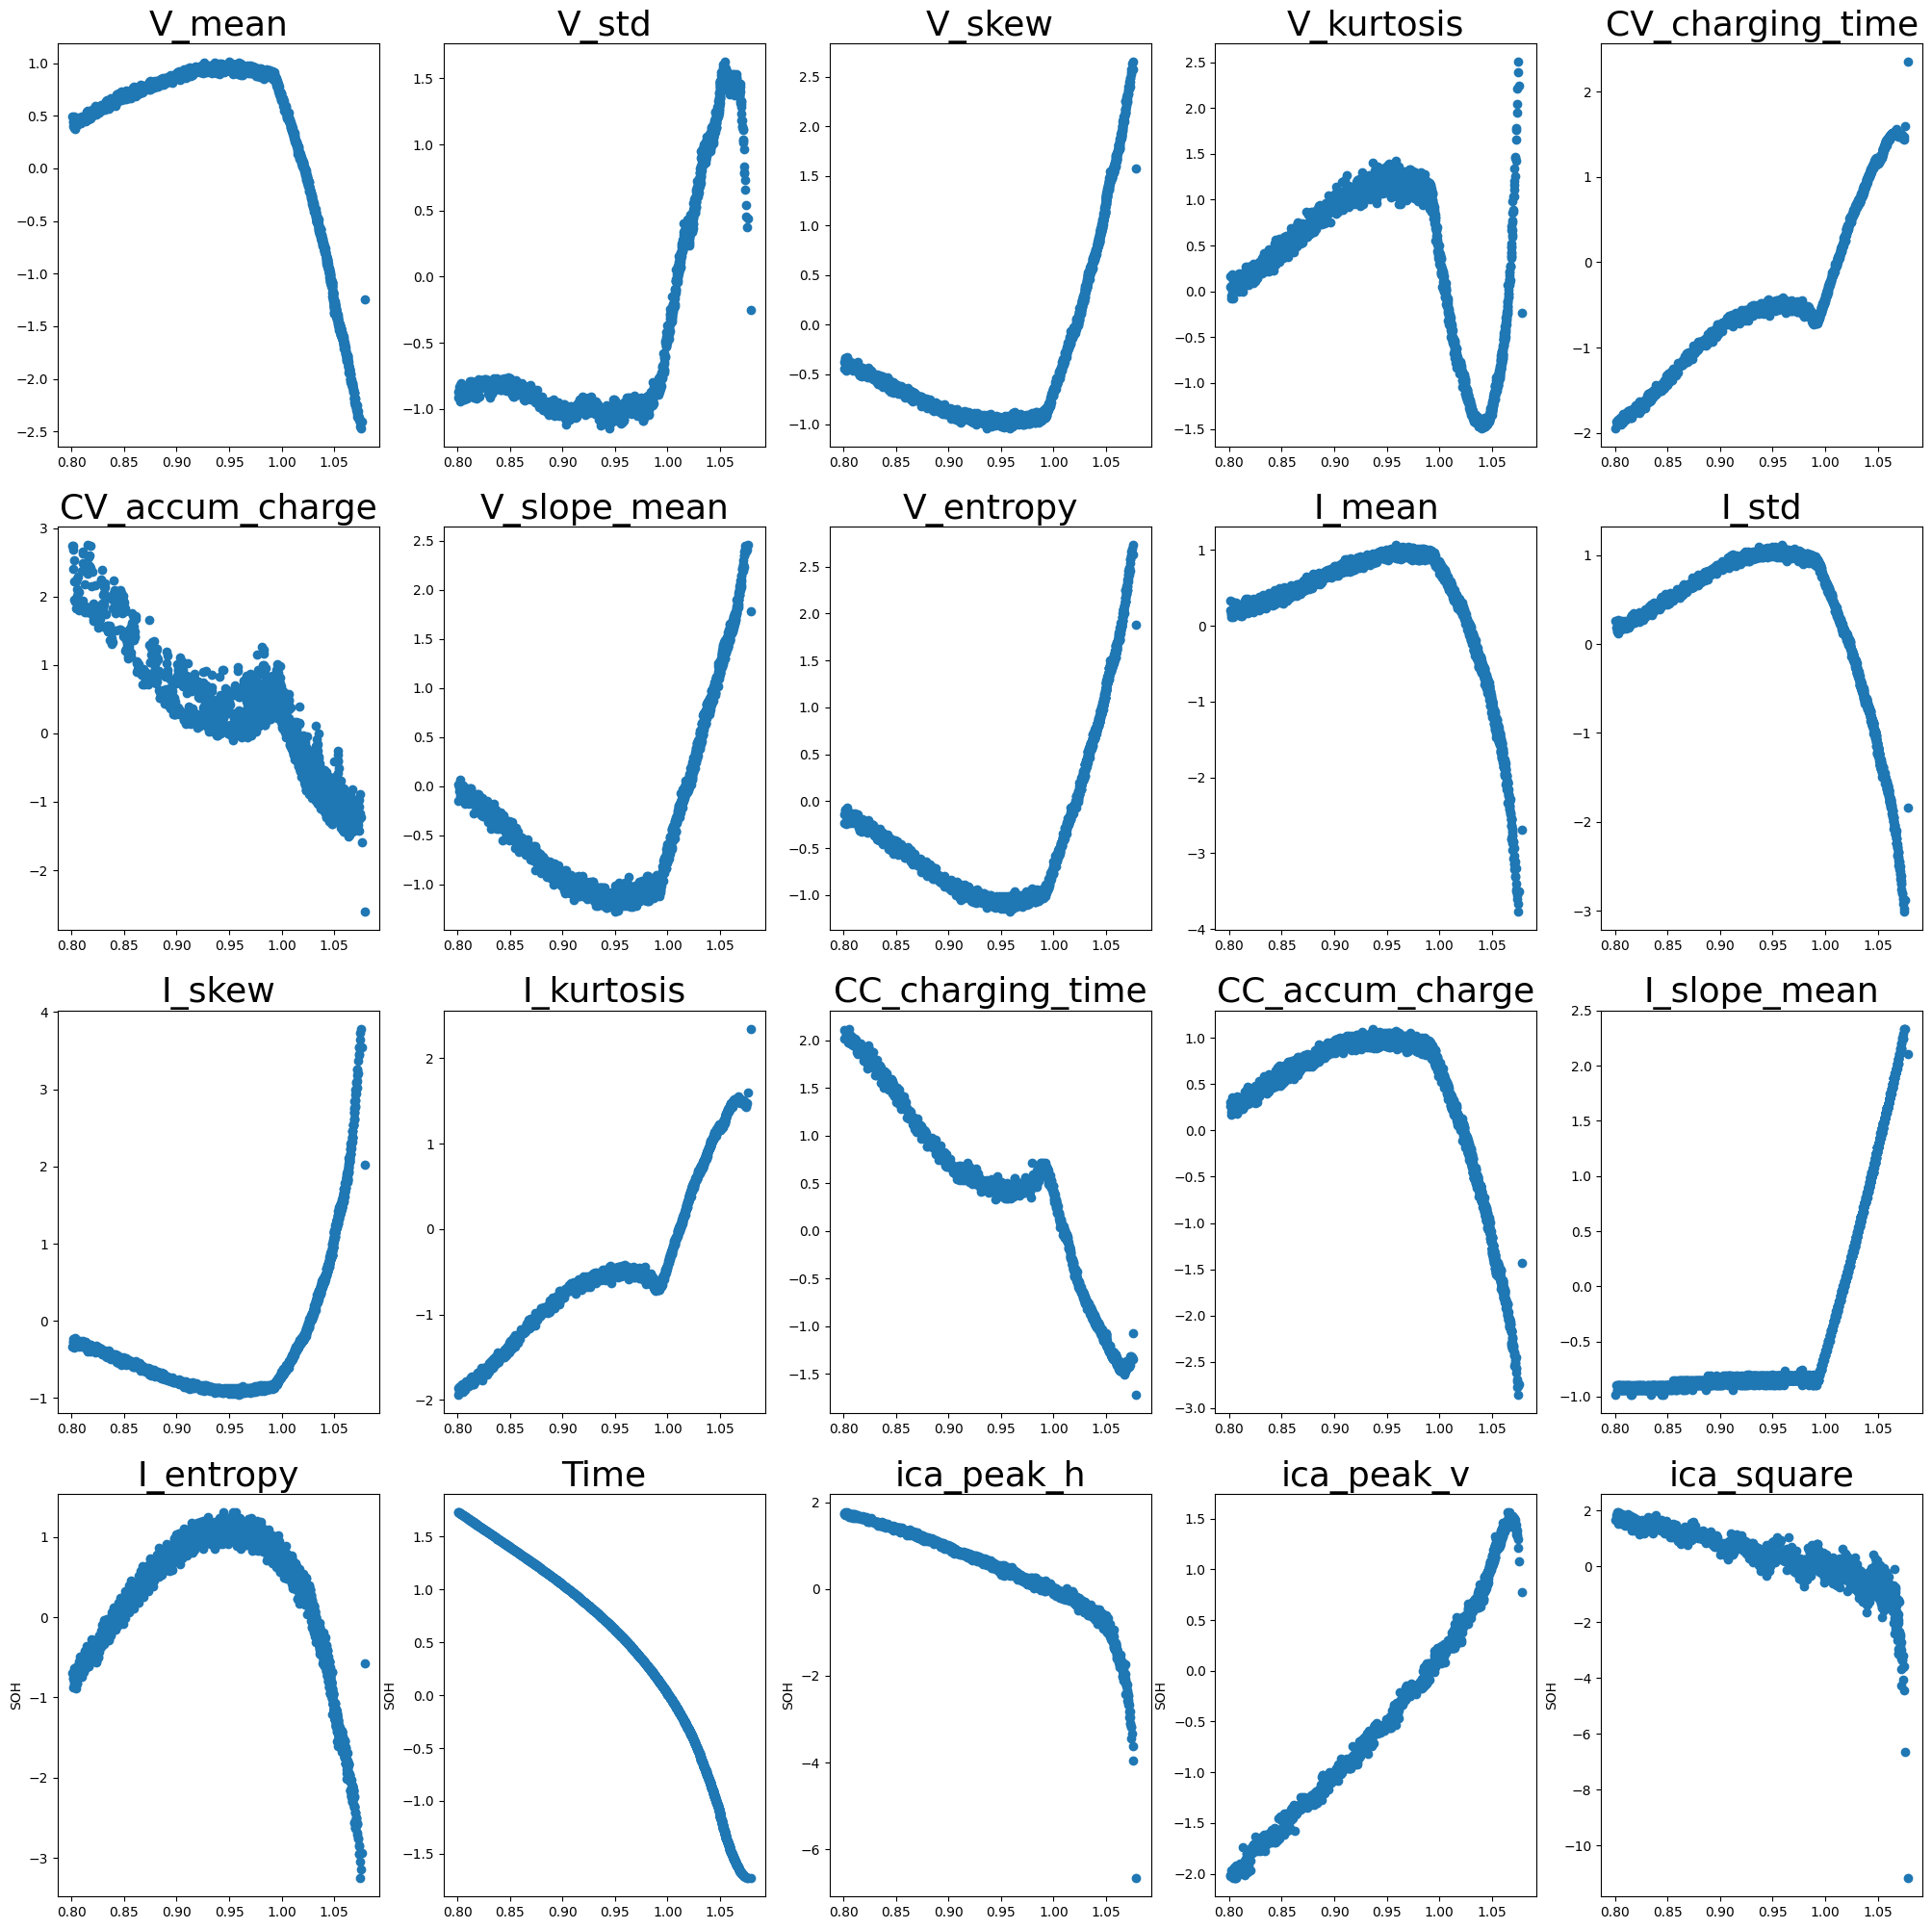

In [24]:
def stats_soh_corr(bat):
    x = np.concatenate([bat.X.cpu().detach().numpy(),
                    bat.ica, 
                    bat.y.cpu().detach().numpy().reshape(-1, 1)], axis=-1)
    
    y = bat.y.cpu().detach().numpy().reshape(-1, 1)
    fig, axes = plt.subplots(4, 5, figsize=(25 ,25))
    
    for i, ax in enumerate(axes.flatten()):
        ax.scatter(y, x[:, i])
        ax.set_title(columns[i], fontsize=26)
        if i >= 15:
            ax.set_ylabel('SOH')

        
        
        
stats_soh_corr(bat)
        

In [6]:
bat = Battery('/kaggle/input/hust-dataset/our_data/1-4.pkl')

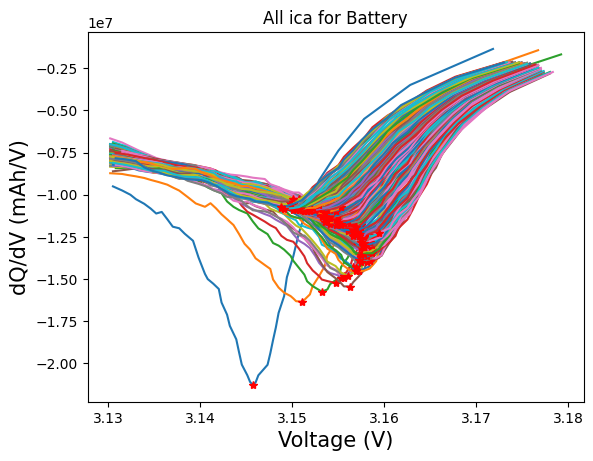

In [22]:
bat.build_ica(num=300, diap=(3.13, 3.18), )

In [11]:
FILE_WAY = '/kaggle/input/hust-dataset/our_data/'
test_idx = ['1-4','1-8','2-4','2-8',
               '3-4','3-8','4-4','4-8',
               '5-4','5-7','6-4','6-8',
               '7-4','7-8','8-4','8-8',
               '9-4','9-8','10-4','10-8']
all_bats = next(iter(os.walk(FILE_WAY)))[2]
train_bats = [Battery(f'{FILE_WAY}{i}') for i in tqdm(all_bats) if i not in test_idx]
print('TRAIN BATTARIES DOWNLOADED')
test_bats = [Battery(f'{FILE_WAY}/{i}.pkl') for i in tqdm(test_idx)]
print('DONE')


  0%|          | 0/77 [00:00<?, ?it/s]

TRAIN BATTARIES DOWNLOADED


  0%|          | 0/20 [00:00<?, ?it/s]

DONE


In [12]:
X_train, y_train, tr_dl = get_data(train_bats, ica=True)
X_test, y_test, test_dl = get_data(test_bats, ica=True)

In [14]:
pinn_hust = PINN(19)

train_losses, val_losses = train_pinn(pinn_hust, epochs=200, tr_dl=tr_dl, val_dl=test_dl, alpha=0.5, beta=0.2)

Training PINN:   0%|          | 0/200 [00:00<?, ?it/s]

In [19]:
bat = Battery(
    '/kaggle/input/hust-dataset/our_data/1-1.pkl'
)

R2 score = 0.996
rmse = 0.441%
mae = 0.004


{'r2': 0.9964478910741122, 'rmse': 0.004406739, 'mae': 0.0035627976}

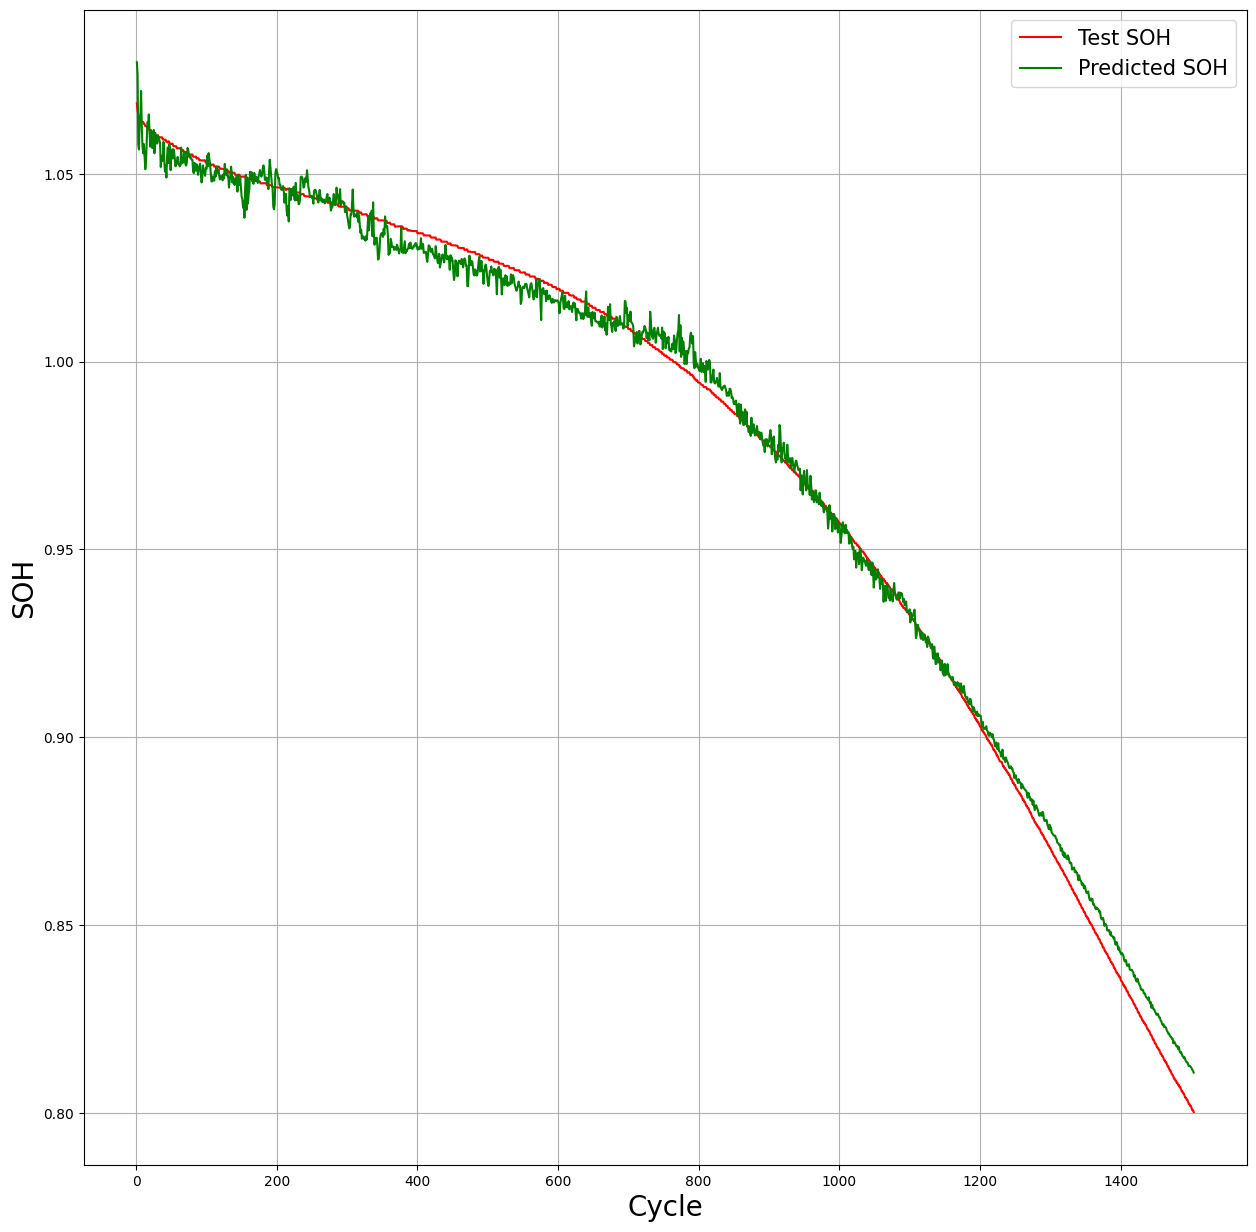

In [22]:
X = torch.cat([bat.X, torch.tensor(bat.ica, dtype=torch.float32).to(device)], -1).to(device)


pinn_hust.eval()
pred = pinn_hust(X)[0]
results(bat.y, pred)

In [23]:
torch.save(pinn_hust.state_dict(), '/kaggle/working/pinn_hust.pt')

In [13]:
pinn_full = PINN()

train_losses, val_losses = train_pinn(pinn_full, epochs=200, tr_dl=tr_dl, val_dl=test_dl, alpha=0.5, beta=0.2)

Training PINN:   0%|          | 0/200 [00:00<?, ?it/s]

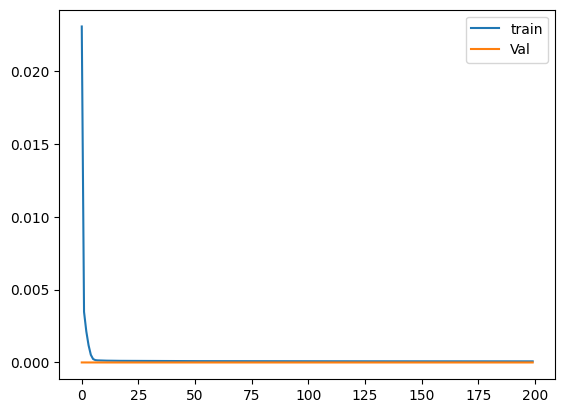

In [14]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='Val')
plt.legend()

R2 score = 0.994
rmse = 0.580%
mae = 0.005
R2 score = 0.993
rmse = 0.609%
mae = 0.005
R2 score = 0.993
rmse = 0.609%
mae = 0.005


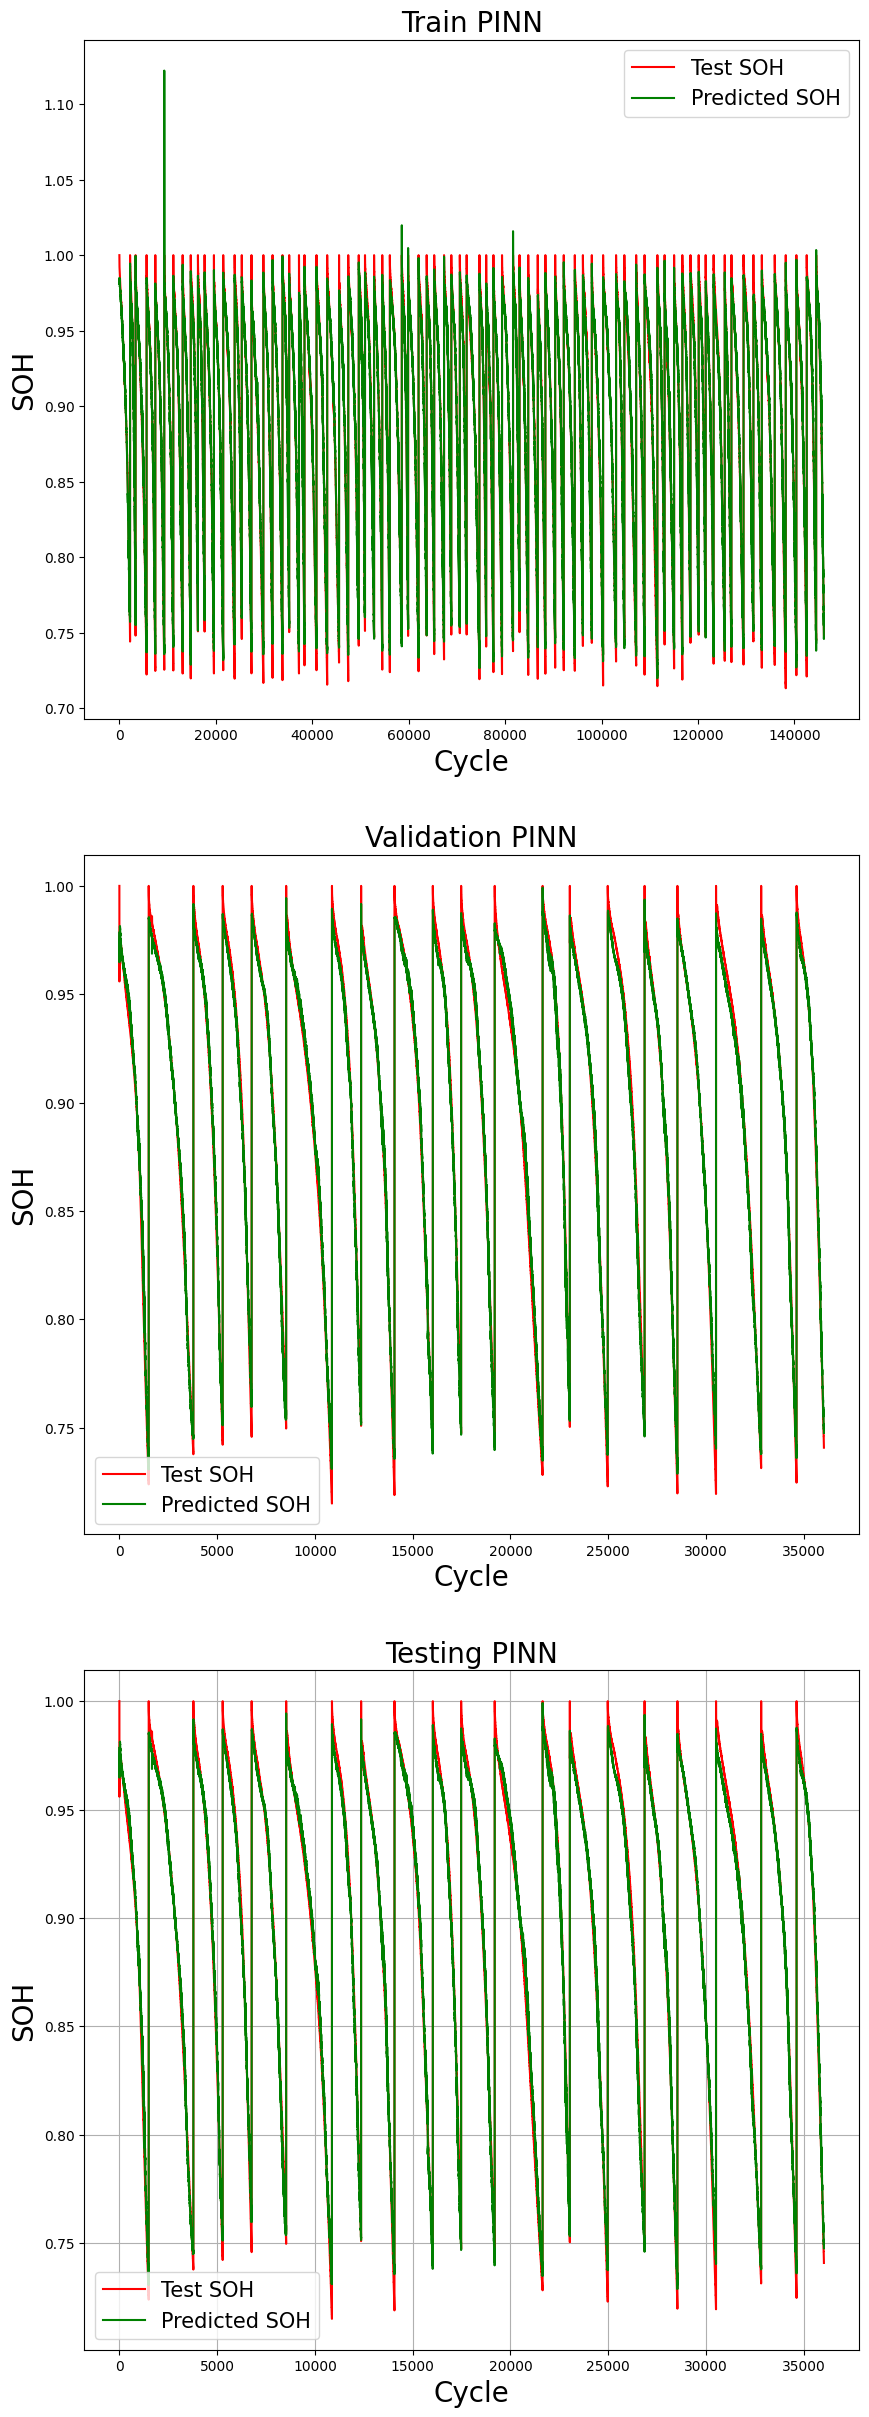

In [15]:
test_pinn(pinn_full, X_train=X_train,
          y_train=y_train, X_val = X_test, y_val=y_test, X_test=X_test, y_test=y_test)

In [8]:
X_train_ica, y_train_ica, tr_dl_ica = get_data(train_bats, ica=True)
X_test_ica, y_test_ica, test_dl_ica = get_data(test_bats, ica=True)

In [14]:
pinn_full_ica = PINN(feat_dim=19)

train_losses, val_losses = train_pinn(pinn_full_ica, epochs=200, tr_dl=tr_dl_ica, val_dl=test_dl_ica, alpha=0.5, beta=0.2)


Training PINN:   0%|          | 0/200 [00:00<?, ?it/s]

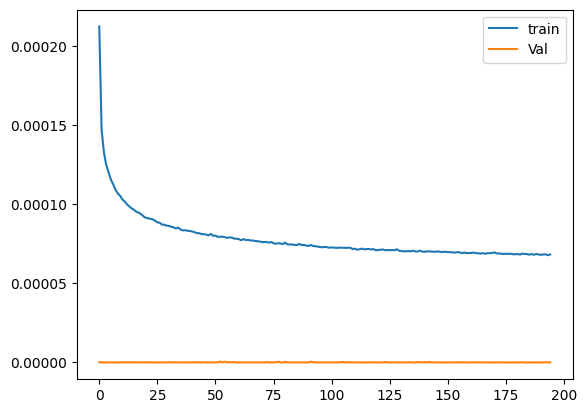

In [15]:
plt.plot(train_losses[5:], label='train')
plt.plot(val_losses[5:], label='Val')
plt.legend()

R2 score = 0.995
rmse = 0.486%
mae = 0.004
R2 score = 0.995
rmse = 0.520%
mae = 0.004


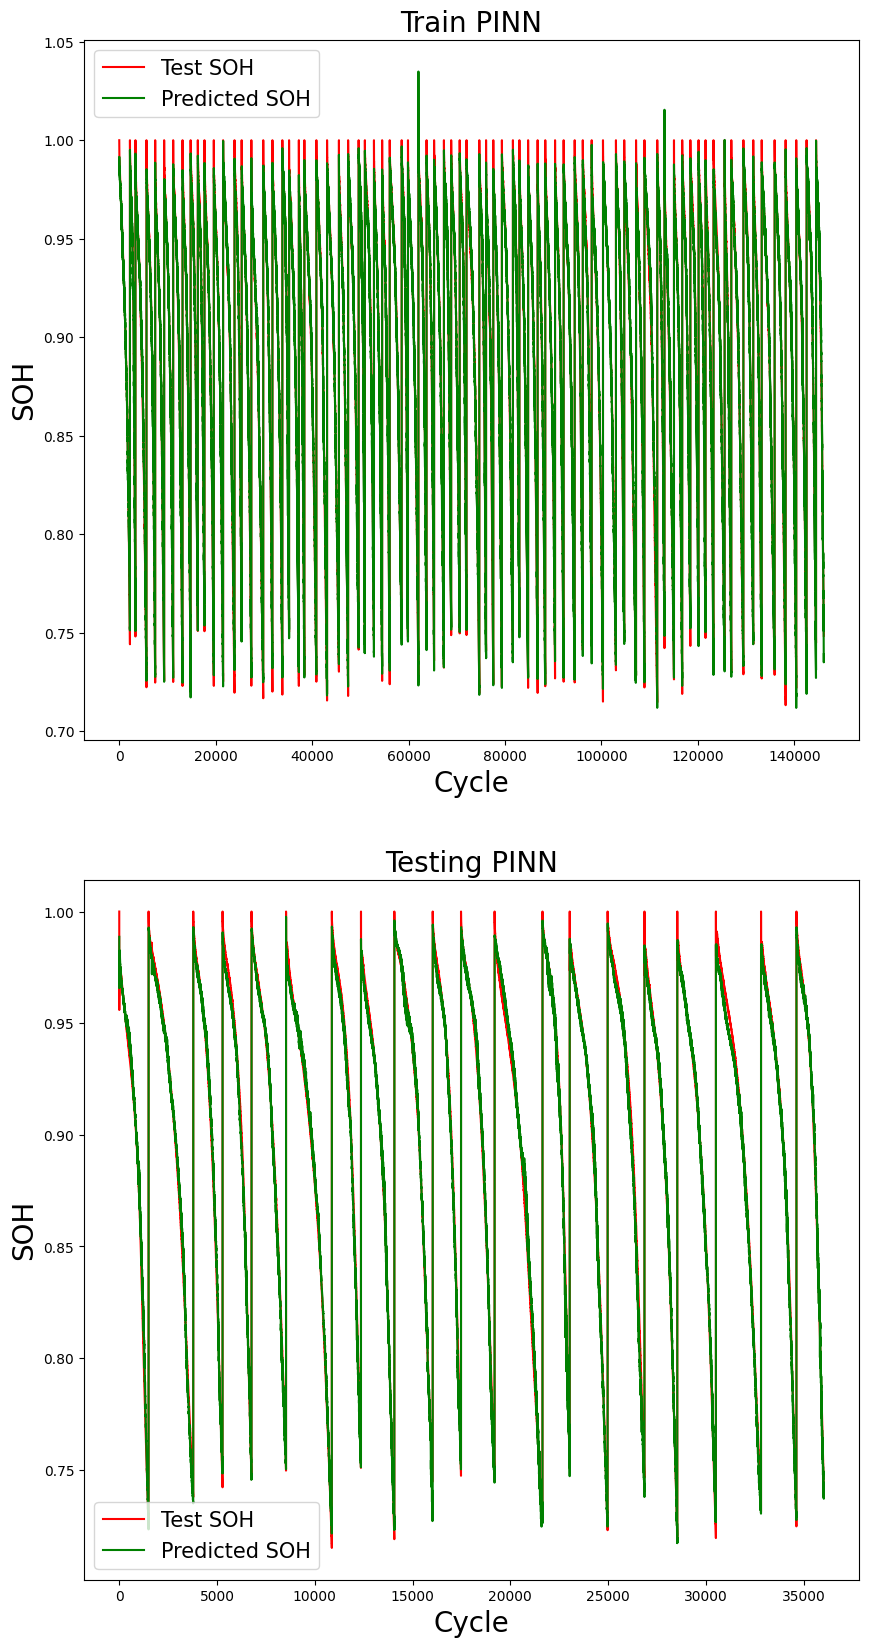

In [23]:
test_pinn(pinn_full_ica, X_train=X_train_ica,
          y_train=y_train_ica, X_val = None, y_val=None, X_test=X_test_ica, y_test=y_test_ica)

In [27]:
torch.save(pinn_full_ica.state_dict(), '/kaggle/working/hust_pinn_ica.pt')

In [122]:
class Battery_TJU:

    
    def __init__(self, path, batch_size=32, stats_mode='auto', nominal_capacity=2500):
        # device auto
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


        df = pd.read_csv(path)
        self.cycle_life = len(df['cycle number'].unique())
        self.cycle_data = {i: df[df['cycle number'] == i] for i in range(1, self.cycle_life + 1)}

        self.capacity = np.array([self.cycle_data[i][['Q discharge/mA.h', 'Q charge/mA.h']].max().max() for i in range(1, self.cycle_life+1)])
        if nominal_capacity is None:
            nominal_capacity = self.capacity.max()
        self.soh = (self.capacity / nominal_capacity).astype(np.float32)  # raw SOH values

        self.cccv_tables = [self.get_CCCV_stage(i) for i in range(1, self.cycle_life+1)]

        stats_list = [self._stats_from_table(df, mode=stats_mode) for df in self.cccv_tables]
        self.stats = np.vstack(stats_list).astype(np.float32)  # shape (N,16)

        N = self.stats.shape[0]
        self.time = (np.arange(N) / float(N)).reshape(-1,1).astype(np.float32)
        self._ica_features()

        X_np = np.hstack([self.stats, self.time])        # (N,17)
        y_np = self.soh.reshape(-1,1)                    # (N,1)
        scaler = StandardScaler()
        X_np = scaler.fit_transform(X_np)
        self.X = torch.tensor(X_np, dtype=torch.float32, device=self.device)
        self.y = torch.tensor(y_np, dtype=torch.float32, device=self.device)



    def get_CCCV_stage(self, cycle):
        df = self.cycle_data[cycle]
        return df[df['<I>/mA'] > 0]

    def _stats_for_signal(self, sig, time_seg):
        sig = np.array(sig, dtype=float)
        dt = np.gradient(time_seg)
        slope = np.gradient(sig, time_seg)
        hist, _ = np.histogram(sig, bins=30, density=True)
        hist = hist + 1e-12
        features = np.array([
            np.mean(sig),
            np.std(sig),
            skew(sig),
            kurtosis(sig),
            time_seg[-1] - time_seg[0],
            np.sum(sig * dt),
            np.mean(np.abs(slope)),
            entropy(hist)
        ], dtype=float)
        return features

    def _stats_from_table(self, df_cccv, mode='auto'):
        V = df_cccv['Ecell/V'].values.astype(float)
        I = df_cccv['<I>/mA'].values.astype(float)
        T = df_cccv['time/s'].values.astype(float)

        if mode == 'auto':
            v_min = V.max() - 0.5
            mask_v = (V >= v_min) & (V <= V.max())
            mask_i = np.ones_like(I, dtype=bool)
        else:
            mask_v = np.ones_like(V, dtype=bool)
            mask_i = np.ones_like(I, dtype=bool)

        V_seg = V[mask_v]
        T_v = T[mask_v]
        I_seg = I[mask_i]
        T_i = T[mask_i]

        feat_V = self._stats_for_signal(V_seg, T_v)
        feat_I = self._stats_for_signal(I_seg, T_i)
        return np.concatenate([feat_V, feat_I], axis=0)

    def _ica_features(self):
        feats = []
        dqdv_list = []
        volt_list = []
        for cycle in range(1, self.cycle_life+1):
            df = self.cycle_data[cycle]
            df = df[df['Q discharge/mA.h'] > 0]
            voltage = df['Ecell/V'].values.astype(float)
            current = df['<I>/mA'].values.astype(float)
            time = df['time/s'].values.astype(float)

            dt = np.diff(time, prepend=time[0]) / 3600.0
            Q = np.cumsum(np.abs(current) * dt)
            if Q.shape[0] < 4:
                feats.append(list(np.array(feats).mean(axis=0)))
                print(f'{cycle} мало измерений')
                continue


            dQ = np.gradient(Q)
            dV = np.gradient(voltage)
            dQ_dV = dQ / (dV + 1e-8)
            dQ_dV_smooth = savgol_filter(dQ_dV, window_length=min(31, dQ_dV.shape[0] if dQ_dV.shape[0]%2==1 else dQ_dV.shape[0]-1), polyorder=2) \
                            if dQ_dV.shape[0] >= 5 else dQ_dV
            peak_height = np.min(dQ_dV_smooth)
            peak_idx = np.argmin(dQ_dV_smooth)
            peak_voltage = voltage[peak_idx]
            area_under_curve = np.trapz(dQ_dV_smooth, voltage)
            feats.append([peak_height, peak_voltage, area_under_curve])
            dqdv_list.append(dQ_dV_smooth)
            volt_list.append(voltage)

        self.ica = np.array(feats, dtype=float)
        scaler = StandardScaler()
        self.ica = scaler.fit_transform(self.ica)
        self.dqdv = dqdv_list
        self.volt = volt_list
        
    def build_ica(self, diap=(float('-inf'), float('inf')), num=100):
        fig, ax = plt.subplots()
        for n, (v, ic) in enumerate(zip(self.volt, self.dqdv)):
            if n > num: 
                break
            mask = (v > diap[0]) & (v < diap[1])
            ax.plot(v[mask], 1000 * ic[mask])
            dqdv_max = ic.min()
            v_max = v[ic.argmin()]
            ax.plot(v_max, 1000 * dqdv_max, marker='*', color='red')
        ax.set_xlabel(r'Voltage (V)', fontsize=15)
        ax.set_ylabel(r'dQ/dV (mAh/V)', fontsize=15)
        ax.set_title(f'All ica for {self}')
    
    def __str__(self):
        return 'Battery'



In [137]:
bats_path_tju = next(iter(os.walk('/kaggle/input/tju-battery-dataset')))[2]
path_tju = '/kaggle/input/tju-battery-dataset/'
bats_tju = [Battery_TJU(f'{path_tju}{i}') for i in tqdm(bats_path_tju)]

  0%|          | 0/9 [00:00<?, ?it/s]

911 мало измерений
867 мало измерений


In [138]:
pinn_ica = PINN(feat_dim=19)
state_dict = torch.load('/kaggle/input/hust-ica/pytorch/default/1/hust_pinn_ica.pt', map_location='cpu') 

pinn_ica.load_state_dict(state_dict)
pinn_ica = pinn_ica.to(device)

In [139]:
X_tju, y_tju, dl_tju = get_data(bats_tju, ica=False)

R2 score = -0.267
rmse = 11.175%
mae = 0.101


{'r2': -0.26712140862840905, 'rmse': 0.11175057, 'mae': 0.10127386}

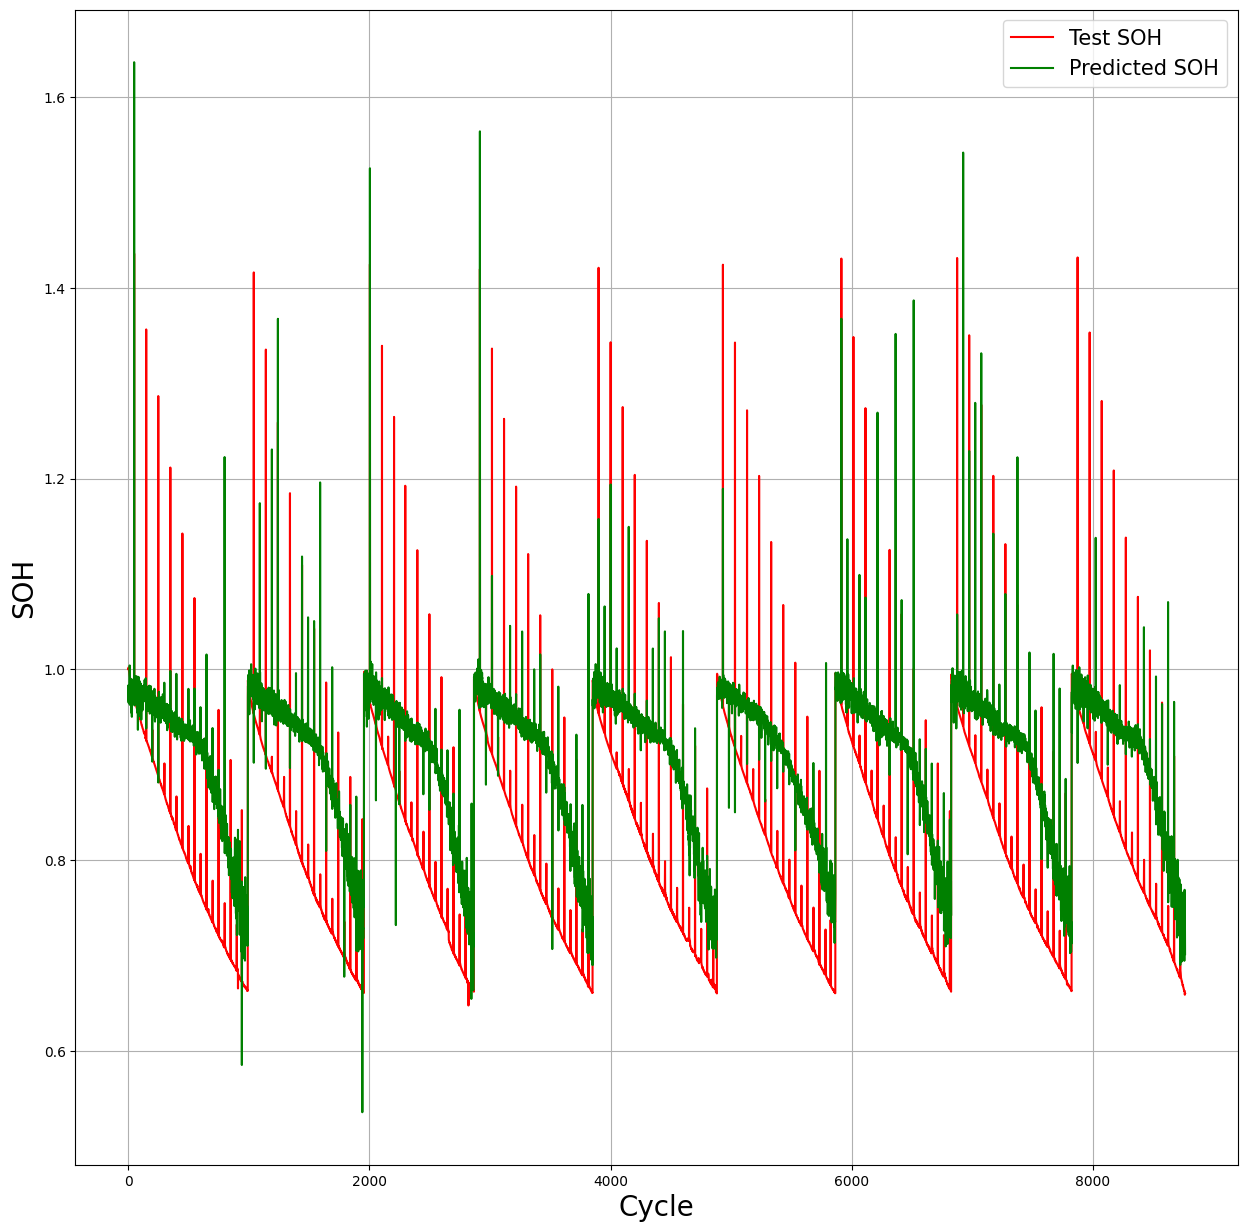

In [140]:
preds = pinn_ica(X_tju)[0].detach().cpu().numpy()
results(y_tju.detach().cpu().numpy(), preds)